   #                              Data Science Mini-Project
   
   
# The assignment

   GEICO provides a number of ways for its policyholders to make payments. While our service counselors can take payments over the phone, it is more cost-efficient for customers to make payments through our self-service channels such as online or through the automated phone system.  We would like to use a predictive model to select people to receive a pre-emptive e-mail message designed to encourage them to pay online.  
   
You have been tasked with identifying which customers are likely to make a service payment call in the next 5 days. The attached file contains data on customers who have had a bill due in the next 5 days and whether they made a service payment call. Construct a model that predicts the likelihood that each policyholder will make a service payment call (CALL_FLAG=1). You may use whatever methods you see fit. 


#                                  My Solution

(1) setup utility functions

(2) Load Dataset

(3) Clean Data

        3.1) remove NaN

        3.2) replace NONE by 0 for CustomerSegment

        3.3) identifying missing data, 

(4) Convert all to numerical 

(5) Handle Data imbalance

         1) Oversample the minority class by adding them five times, which are the rows of Call_Flag = 1
            Afterwards, shuffle rows.

         2) Undersample the majority group , which are the rows of Call_Flag = 0

(6) Feature Engineer

    6.a) Generate correlation matrix of the dataset. Reduce the correlated columns by mainly removing *_6M.
         

(7) Model Building

    Random Forest model is utilized. 

(8) Model Validation

       Perform cross validation.

       confusion_matrix =
                    [[14967  4793]
                     [ 4456 15474]]
                     
    accuracy = 0.7669690098261527
    recall = 0.4916724154922637
    typeI error = 0.23649282084176249
    typeII error = 0.2294187303712094


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import re
import random

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn import ensemble

Using TensorFlow backend.


# Setup Utility functions

In [2]:
# filtering out substring
def filter_str_onDataFrame(df, colname, reg):
    result = []
    for line in df[colname]:
        x = re.findall(reg, line)
        result.append(''.join(x))
    df[colname] = result

In [3]:
# add new DataFrame on specific index row
def insert_row_intoDataFrame(idx, df, df_insert):
    df_bef = df.iloc[:idx, ]
    df_aft = df.iloc[idx:, ]

    df = df_bef.append(df_insert).append(df_aft).reset_index(drop = True)

    return df

# Load Dataset

In [4]:
df_raw = pd.read_csv('DS_MiniProject_ANON.csv')
df_raw.head(3)

,DATE_FOR,RTD_ST_CD,CustomerSegment,Tenure,Age,MART_STATUS,GENDER,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,...,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,NOT_DI_3M,NOT_DI_6M,EVENT1_30_FLAG,EVENT2_90_SUM,LOGINS,POLICYPURCHASECHANNEL,Call_Flag
0,5/19/2014,ST_S0,1,16.175222,78.403833,MS_S0,F,0.0,0.0,1.0,...,2,0,3,0,0,0,0,0,0,0
1,5/17/2014,ST_S0,1,15.931554,70.989733,MS_S1,F,0.0,6.0,0.0,...,0,3,3,0,0,0,0,0,0,0
2,5/15/2014,ST_S0,1,15.937029,87.578371,MS_S2,M,0.0,0.0,10.0,...,0,0,6,0,0,0,0,0,0,0


# Clean Dataset

1) remove NaN

2) replace NONE by 0 for CustomerSegment

3) identifying missing data, 

In [5]:
# drop n/a
df_raw.dropna(inplace=True)
df_raw.reset_index(drop=True, inplace=True)

In [6]:
# quick scanning data, finding any NaN or NONE
#print(df_raw.groupby(['DATE_FOR']).count())
#print(df_raw.groupby(['RTD_ST_CD']).count())
print(df_raw.groupby(['CustomerSegment']).count())
#print(df_raw.groupby(['Tenure']).count())
#print(df_raw.groupby(['Age']).count())
#print(df_raw.groupby(['MART_STATUS']).count())
#print(df_raw.groupby(['GENDER']).count())
#print(df_raw.groupby(['CHANNEL1_6M']).count())
#print(df_raw.groupby(['CHANNEL2_6M']).count())
#print(df_raw.groupby(['CHANNEL3_6M']).count())
#print(df_raw.groupby(['CHANNEL4_6M']).count())
#print(df_raw.groupby(['CHANNEL5_6M']).count())
#print(df_raw.groupby(['METHOD1_6M']).count())
#print(df_raw.groupby(['RECENT_PAYMENT']).count())
#print(df_raw.groupby(['PAYMENTS_6M']).count())
#print(df_raw.groupby(['CHANNEL1_3M']).count())
#print(df_raw.groupby(['CHANNEL2_3M']).count())
#print(df_raw.groupby(['CHANNEL3_3M']).count())
#print(df_raw.groupby(['CHANNEL4_3M']).count())
#print(df_raw.groupby(['CHANNEL5_3M']).count())
#print(df_raw.groupby(['METHOD1_3M']).count())
#print(df_raw.groupby(['PAYMENTS_3M']).count())
#print(df_raw.groupby(['NOT_DI_3M']).count())
#print(df_raw.groupby(['NOT_DI_6M']).count())
#print(df_raw.groupby(['EVENT1_30_FLAG']).count())
#print(df_raw.groupby(['EVENT2_90_SUM']).count())
#print(df_raw.groupby(['LOGINS']).count())
#print(df_raw.groupby(['POLICYPURCHASECHANNEL']).count())
#print(df_raw.groupby(['Call_Flag']).count())

                 DATE_FOR  RTD_ST_CD  Tenure    Age  MART_STATUS  GENDER  \
CustomerSegment                                                            
1                   95349      95349   95349  95349        95349   95349   
2                   25226      25226   25226  25226        25226   25226   
3                    5019       5019    5019   5019         5019    5019   
NONE                 3683       3683    3683   3683         3683    3683   

                 CHANNEL1_6M  CHANNEL2_6M  CHANNEL3_6M  CHANNEL4_6M  \
CustomerSegment                                                       
1                      95349        95349        95349        95349   
2                      25226        25226        25226        25226   
3                       5019         5019         5019         5019   
NONE                    3683         3683         3683         3683   

                   ...      CHANNEL5_3M  METHOD1_3M  PAYMENTS_3M  NOT_DI_3M  \
CustomerSegment    ...               

In [7]:
# replacing NONE by 0
df_raw['CustomerSegment'] = [0 if x == 'NONE' else x for x in df_raw['CustomerSegment']]

In [8]:
# fill missing data
# Here it demonstrates there are no missing values
df_raw.isnull().any()
print(df_raw.isnull().sum())

DATE_FOR                 0
RTD_ST_CD                0
CustomerSegment          0
Tenure                   0
Age                      0
MART_STATUS              0
GENDER                   0
CHANNEL1_6M              0
CHANNEL2_6M              0
CHANNEL3_6M              0
CHANNEL4_6M              0
CHANNEL5_6M              0
METHOD1_6M               0
RECENT_PAYMENT           0
PAYMENTS_6M              0
CHANNEL1_3M              0
CHANNEL2_3M              0
CHANNEL3_3M              0
CHANNEL4_3M              0
CHANNEL5_3M              0
METHOD1_3M               0
PAYMENTS_3M              0
NOT_DI_3M                0
NOT_DI_6M                0
EVENT1_30_FLAG           0
EVENT2_90_SUM            0
LOGINS                   0
POLICYPURCHASECHANNEL    0
Call_Flag                0
dtype: int64


# Convert all values to numerical

In [9]:
# convert all values to numerical
# DATE_FOR convert to mmddyyyy
token = [x.rstrip().split('/') for x in df_raw['DATE_FOR']]
df_raw['DATE_FOR'] = [x[0] + x[1] + x[2] for x in token]

# RTD_ST_CD stripped off the first four characters
filter_str_onDataFrame(df_raw, 'RTD_ST_CD', '\d')

# MART_STATUS stripped off the first four characters
filter_str_onDataFrame(df_raw, 'MART_STATUS', '\d')

# GENDER convert to 0 for M, 1 for F
df_raw['GENDER'] = [0 if line == 'M' else 1 for line in df_raw['GENDER'] ]

In [10]:
df_raw.head(2)

,DATE_FOR,RTD_ST_CD,CustomerSegment,Tenure,Age,MART_STATUS,GENDER,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,...,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,NOT_DI_3M,NOT_DI_6M,EVENT1_30_FLAG,EVENT2_90_SUM,LOGINS,POLICYPURCHASECHANNEL,Call_Flag
0,5192014,0,1,16.175222,78.403833,0,1,0.0,0.0,1.0,...,2,0,3,0,0,0,0,0,0,0
1,5172014,0,1,15.931554,70.989733,1,1,0.0,6.0,0.0,...,0,3,3,0,0,0,0,0,0,0


In [11]:
df_flag1 = df_raw[df_raw.Call_Flag>0]
print('The shape of whole dataset')
print(df_raw.shape)
print('The shape of sub dataset with Call_Flag=1')
print(df_flag1.shape)

The shape of whole dataset
(129277, 29)
The shape of sub dataset with Call_Flag=1
(4725, 29)


#  The dataset is overly imbalanced

   To make dataset balanced, 
   
       1) I will oversample the minority class, which are the rows of Call_Flag = 1
   
       2) I will undersample the majority group, which are the rows of Call_Flag = 0
   

In [12]:
# oversampling
num_sample = 5
for i in range(num_sample):                   
    ran = np.random.uniform(0,1)
    idx = int(ran*(df_raw.shape[0]))
    df_raw = insert_row_intoDataFrame(idx, df_raw, df_flag1)
    
df_raw = shuffle(df_raw)   
df_raw = shuffle(df_raw)
print('Done oversampling')
print('The shape of whole dataset after oversampling')
print(df_raw.shape)

Done oversampling
The shape of whole dataset after oversampling
(152902, 29)


In [21]:
# undersampling
X_raw = df_raw.drop(['Call_Flag'], axis=1)
y_raw = df_raw['Call_Flag']
print('Before resample')
print('Dataset rows = {}'.format(X_raw.shape[0]))
rus = RandomUnderSampler(random_state=42)
X_arr, y_arr = rus.fit_resample(X_raw, y_raw)
print('After resample')
print('Dataset rows = {}'.format(X_arr.shape[0]))

Before resample
Dataset rows = 152902
After resample
Dataset rows = 56700


In [22]:
X = pd.DataFrame(X_arr, columns=X_raw.columns)
y = pd.DataFrame(y_arr, columns=['Call_Flag'])
print('number of rows in flag 0 sample = {}'.format(y[y.Call_Flag<1].shape[0]))
print('number of rows in flag 1 sample = {}'.format(y[y.Call_Flag>0].shape[0]))
print('Now the dataset is balanced with 1:1 classes ratio')

number of rows in flag 0 sample = 28350
number of rows in flag 1 sample = 28350
Now the dataset is balanced with 1:1 classes ratio


# Feature Engineering

In [23]:
# check correlation of df_raw
df_corr = df_raw.corr()


In [24]:
# filtering out elements which are greater than 0.85
print(df_corr[df_corr.iloc[:,:]>0.85])

                       Tenure  Age  GENDER  CHANNEL1_6M  CHANNEL2_6M  \
Tenure                    1.0  NaN     NaN          NaN          NaN   
Age                       NaN  1.0     NaN          NaN          NaN   
GENDER                    NaN  NaN     1.0          NaN          NaN   
CHANNEL1_6M               NaN  NaN     NaN     1.000000          NaN   
CHANNEL2_6M               NaN  NaN     NaN          NaN     1.000000   
CHANNEL3_6M               NaN  NaN     NaN          NaN          NaN   
CHANNEL4_6M               NaN  NaN     NaN          NaN          NaN   
CHANNEL5_6M               NaN  NaN     NaN          NaN          NaN   
METHOD1_6M                NaN  NaN     NaN          NaN          NaN   
RECENT_PAYMENT            NaN  NaN     NaN          NaN          NaN   
PAYMENTS_6M               NaN  NaN     NaN          NaN          NaN   
CHANNEL1_3M               NaN  NaN     NaN     0.909384          NaN   
CHANNEL2_3M               NaN  NaN     NaN          NaN     0.94

# From the correlation matrix, several columns are strongly correlated.

  below are strongly correlated features:
  
    CHANNEL1_3M vs.	CHANNEL1_6M  
    CHANNEL2_3M vs.	CHANNEL2_6M 
    CHANNEL3_3M vs.	CHANNEL3_6M  
    CHANNEL4_3M vs.	CHANNEL4_6M 
    CHANNEL5_3M vs.	CHANNEL5_6M  
    METHOD1_3M  vs. METHOD1_6M
    PAYMENTS_3M vs. PAYMENTS_6M

To keep principal features and keep analysis simple, I will drop the features with 6M. because more recent features 3M are more relevant to cunsumers' behaviors

In [25]:
X.drop(['CHANNEL1_6M'], axis=1, inplace=True)
X.drop(['CHANNEL2_6M'], axis=1, inplace=True)
X.drop(['CHANNEL3_6M'], axis=1, inplace=True)
X.drop(['CHANNEL4_6M'], axis=1, inplace=True)
X.drop(['CHANNEL5_6M'], axis=1, inplace=True)
X.drop(['METHOD1_6M'], axis=1, inplace=True)
X.drop(['PAYMENTS_6M'], axis=1, inplace=True)

In [26]:
df_raw.drop(['CHANNEL1_6M'], axis=1, inplace=True)
df_raw.drop(['CHANNEL2_6M'], axis=1, inplace=True)
df_raw.drop(['CHANNEL3_6M'], axis=1, inplace=True)
df_raw.drop(['CHANNEL4_6M'], axis=1, inplace=True)
df_raw.drop(['CHANNEL5_6M'], axis=1, inplace=True)
df_raw.drop(['METHOD1_6M'], axis=1, inplace=True)
df_raw.drop(['PAYMENTS_6M'], axis=1, inplace=True)

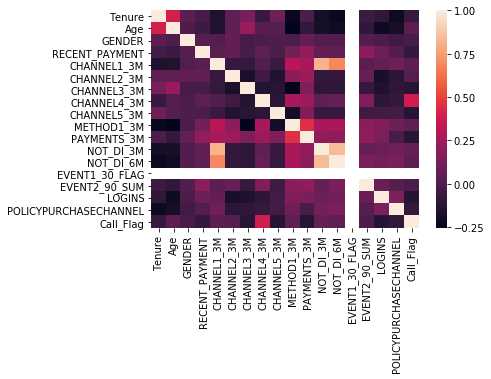

In [27]:
# Now Looking at the correlation of features
corr = df_raw.corr()
sns.heatmap(corr)
plt.show()

# Build Model

In [28]:
# build train & test dataset
trainSize = int(0.70*(X.shape[0]))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=trainSize, random_state=24)

In [29]:
# use Random Forest model
rfc = ensemble.RandomForestClassifier(
    min_samples_split=2,
    min_samples_leaf =1,
    max_features='auto',
    max_depth=5)

#X_train = pd.get_dummies(X_train)
rfc.fit(X_train, y_train)
print('Train Dataset score {}'.format(rfc.score(X_train, y_train)))
#X_test = pd.get_dummies(X_test)
print('Test Dataset score {}'.format(rfc.score(X_test, y_test)))
cross_val_score(rfc, X_train, y_train, cv=4)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Train Dataset score 0.7647518266565886
Test Dataset score 0.7580834803057025


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y wa

array([0.76327723, 0.76156404, 0.76708325, 0.75881879])

In [30]:
out_mat = confusion_matrix(y_train, rfc.predict(X_train))
print(out_mat)
TP = out_mat[0, 0]
TN = out_mat[1, 1]
FP = out_mat[0, 1]
FN = out_mat[1, 0]
accuracy = (TP + TN) / (TP + FP + FN + TN)
recall = TP / (TP + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (FP + TN)

print('accuracy = {}'.format(accuracy))
print('recall = {}'.format(recall))
print('typeI error = {}'.format(1 - specificity))
print('typeII error = {}'.format(1 - sensitivity))

[[15107  4653]
 [ 4684 15246]]
accuracy = 0.7647518266565886
recall = 0.49771027575527954
typeI error = 0.23383084577114432
typeII error = 0.23667323530897888


# Conclusion: 

It is observed that the model predicts 76% accuracy whether the customers will make service calls or not
comparing the actual data. It is under control whether the model overfits. 

The accuracy scores are pretty close to 0.76 for multiple subsets of training dataset. While the accuracy
score for testing dataset is near 0.75. 

When looking into confusion_matrix, there are considerable events are correctly classified as true positive 
or true negative. 

The type I error, i.e. false positive rate, is 0.236. The type II error, i.e. false negative error, is 0.229



# Future Development

The low accuracy shows the model has high bias. To reduce the high bias, we can try

    1) more feature engineer

    2) different models
    
A lot of ways to improve the prediction.